# Group 17: 
### Eyad Medhat 221100279 / Hady Aly 221101190 / Mohamed Mahfouz 221101743 / Omar Mady 221100745

# Part 3: Singular Value Decomposition (SVD) for Collaborative Filtering

## Task 1: Data Preparation
1. Load ratings matrix from your new preprocessed dataset.
2. Calculate the average rating for each item.
3. Apply mean-filling: replace missing ratings with the item's average rating.
4. Verify matrix completeness (no missing values).

In [ ]:
from utils import * 

In [9]:
print("Loading data...")
# Load sampled data (matches PCA notebooks)
ratings = load_data()
movies = load_data(table_name='movies.csv')

print(f"Ratings shape: {ratings.shape}")

# Load Target IDs
target_items_df = load_data(table_name='lowest_two_rateditems.csv')
if target_items_df is not None:
    target_ids = target_items_df['movieId'].tolist()[:2]
    print(f"Target Items: {target_ids}")
else:
    target_ids = [1556, 1499]
    print(f"Using Default Target Items: {target_ids}")

# Use full sampled dataset (no manual filtering to 5k)
ratings_filtered = ratings
print(f"Filtered ratings shape: {ratings_filtered.shape}")

Loading data...
 Found cached sample at: ..\data\ml-20m\ratings_cleaned_sampled.csv
 Found requested table at: ..\data\ml-20m\movies.csv
Ratings shape: (1000000, 3)
 Found requested table at: ..\results\tables\lowest_two_rateditems.csv
Target Items: [1556, 1499]
Filtered ratings shape: (1000000, 3)


In [10]:
# 1.1 Load/Pivot to ratings matrix (R)
print("Pivoting...")
R_df = ratings_filtered.pivot(index='userId', columns='movieId', values='rating')

# 1.2 Calculate average rating for each item
item_means = R_df.mean(axis=0)

# 1.3 Apply mean-filling
R_filled = R_df.fillna(item_means)
R = R_filled.values

print(f"Matrix R shape: {R.shape}")

Pivoting...
Matrix R shape: (96345, 1000)


In [11]:
# 1.4 Verify matrix completeness
missing_count = np.isnan(R).sum()
print(f"Missing values count: {missing_count}")
assert missing_count == 0

Missing values count: 0


## Task 2: Full SVD Decomposition
1. Compute the full SVD: $R = U \Sigma V^T$
2. Calculate and save Eigenpairs, Singular Values, $V$, and $U$.
3. Verify orthogonality.
4. Visualize singular values (Scree plot).

In [12]:
# 2.1 Compute R^T R
print("Computing R^T R...")
RtR = np.dot(R.T, R)
print(f"RtR shape: {RtR.shape}")

# 2.2 Eigen decomposition
print("Eigen decomposition...")
eigenvalues, eigenvectors = np.linalg.eigh(RtR)

# Sort in descending order
idx = eigenvalues.argsort()[::-1]
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:, idx]

# 2.3 Calculate Singular Values (Sigma) and V
singular_values = np.sqrt(np.maximum(eigenvalues, 0))
Sigma = np.diag(singular_values)
V = eigenvectors # Columns of V are the eigenvectors of RtR

print(f"Top 5 Singular Values: {singular_values[:5]}")

Computing R^T R...
RtR shape: (1000, 1000)
Eigen decomposition...
Top 5 Singular Values: [35216.37265547    72.43551974    68.4959159     64.46854864
    63.23123018]


In [13]:
# 2.4 Calculate U
# U = R * V * Sigma^-1
print("Calculating U...")
Sigma_inv = np.diag(1 / singular_values)
Sigma_inv[np.isinf(Sigma_inv)] = 0 # Handle division by zero

U = np.dot(np.dot(R, V), Sigma_inv)
print(f"U shape: {U.shape}")

Calculating U...
U shape: (96345, 1000)


In [14]:
# 2.5 Verify Orthogonality
# Check V^T V = I
VtV = np.dot(V.T, V)
valid_V = np.allclose(VtV, np.eye(len(VtV)), atol=1e-4)
print(f"V is orthonormal: {valid_V}")

# Check U^T U = I (for Top K, or all if full rank)
# Since we kept all singular values, U is m x k. U^T U should be I (k x k).
UtU = np.dot(U.T, U)
valid_U = np.allclose(UtU, np.eye(len(UtU)), atol=1e-4)
print(f"U is orthonormal: {valid_U}")

# Check Reconstruction
R_approx = np.dot(np.dot(U, Sigma), V.T)
error = np.linalg.norm(R - R_approx) / np.linalg.norm(R)
print(f"Relative Reconstruction Error: {error}")

V is orthonormal: True
U is orthonormal: True
Relative Reconstruction Error: 1.2254228472322265e-15


    Saved Plot: plots/singular_values.png


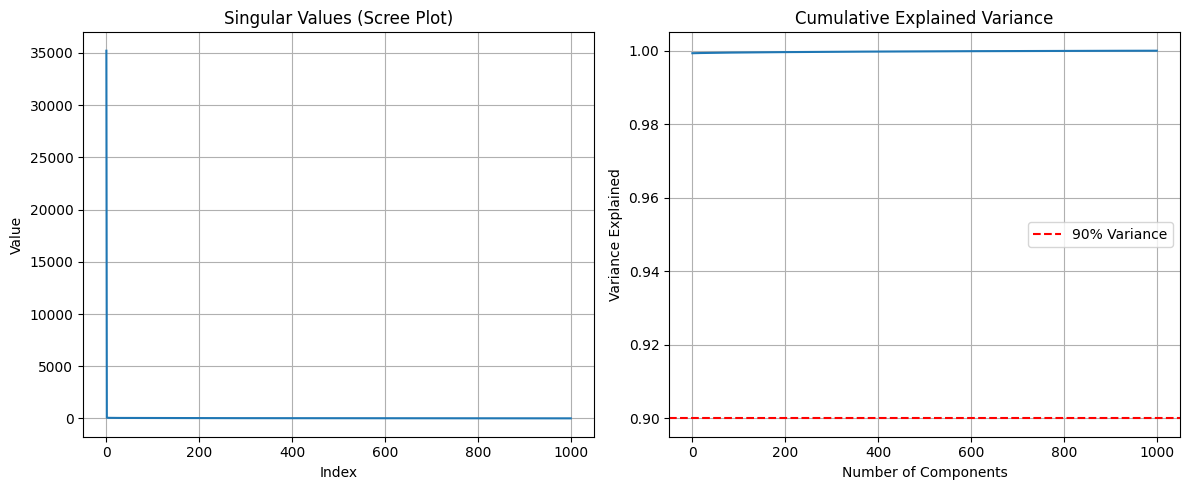

    Saved Plot: plots/cumulative_variance.png


<Figure size 640x480 with 0 Axes>

In [15]:
# 2.6 Visualization
plt.figure(figsize=(12, 5))

# Plot Singular Values
plt.subplot(1, 2, 1)
plt.plot(singular_values)
plt.title('Singular Values (Scree Plot)')
plt.xlabel('Index')
plt.ylabel('Value')
plt.grid(True)
save_plot(plt,'singular_values')

# Plot Cumulative Explained Variance
explained_variance = np.square(singular_values) / np.sum(np.square(singular_values))
cumulative_variance = np.cumsum(explained_variance)

plt.subplot(1, 2, 2)
plt.plot(cumulative_variance)
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Variance Explained')
plt.grid(True)
plt.axhline(y=0.90, color='r', linestyle='--', label='90% Variance')
plt.legend()

plt.tight_layout()
plt.show()
save_plot(plt,'cumulative_variance')

## Task 3: Truncated SVD (Low-Rank Approximation)
1. Implement Truncated SVD for $k = [5, 20, 50, 100]$.
2. For each $k$, compute $\hat{R}_k = U_k \Sigma_k V_k^T$.
3. Calculate MAE and RMSE.
4. Visualize errors and variance retained.

In [16]:
# 3.1 & 3.2 Loop over k
k_values = [5, 20, 50, 100]
mae_values = []
rmse_values = []
variance_retained = []

total_variance = np.sum(np.square(singular_values))

print("{:<5} {:<10} {:<10} {:<15}".format("k", "MAE", "RMSE", "Var Retained"))
print("-"*45)

for k in k_values:
    if k > len(singular_values):
        print(f"Skipping k={k}, max rank is {len(singular_values)}")
        continue

    # Construct Truncated Matrices
    Uk = U[:, :k]
    Sk = np.diag(singular_values[:k])
    VkT = V[:, :k].T
    
    # Approximation
    R_k = np.dot(np.dot(Uk, Sk), VkT)
    
    # 3.3 Calculate Errors
    diff = R - R_k
    mae = np.mean(np.abs(diff))
    rmse = np.sqrt(np.mean(np.square(diff)))
    
    # Calculate Variance Retained
    var_k = np.sum(np.square(singular_values[:k])) / total_variance
    
    mae_values.append(mae)
    rmse_values.append(rmse)
    variance_retained.append(var_k)
    
    print("{:<5} {:<10.4f} {:<10.4f} {:<15.2%}".format(k, mae, rmse, var_k))

k     MAE        RMSE       Var Retained   
---------------------------------------------
5     0.0111     0.0927     99.93%         
20    0.0115     0.0899     99.94%         
50    0.0118     0.0855     99.94%         
100   0.0122     0.0795     99.95%         


    Saved Plot: plots/reconstruction_error_vs_k.png


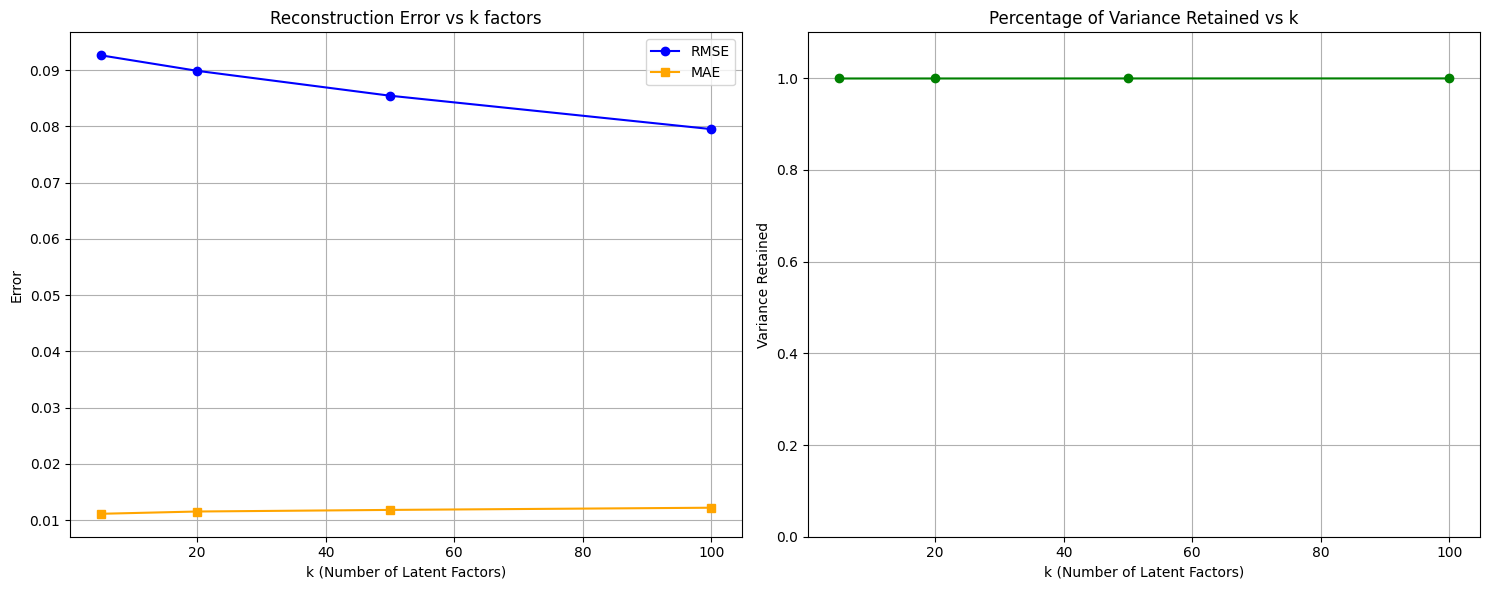

    Saved Plot: plots/precentage_variance_retained_vs_k.png


<Figure size 640x480 with 0 Axes>

In [17]:
# 3.4 Visualization
plt.figure(figsize=(15, 6))

# Reconstruction Error vs k
plt.subplot(1, 2, 1)
plt.plot(k_values, rmse_values, marker='o', label='RMSE', color='blue')
plt.plot(k_values, mae_values, marker='s', label='MAE', color='orange')
plt.title('Reconstruction Error vs k factors')
plt.xlabel('k (Number of Latent Factors)')
plt.ylabel('Error')
plt.legend()
plt.grid(True)
save_plot(plt, 'reconstruction_error_vs_k')

# Variance Retained vs k
plt.subplot(1, 2, 2)
plt.plot(k_values, variance_retained, marker='o', color='green')
plt.title('Percentage of Variance Retained vs k')
plt.xlabel('k (Number of Latent Factors)')
plt.ylabel('Variance Retained')
plt.ylim(0, 1.1)
plt.grid(True)

plt.tight_layout()
plt.show()
save_plot(plt, 'precentage_variance_retained_vs_k')

## Task 4: Rating Prediction with Truncated SVD
1. Select Optimal $k$ (e.g., $k=50$ based on elbow analysis).
2. Select target users and items.
3. Predict ratings using latent factor approximation: $\hat{r}_{ui} = u_k^T \cdot \Sigma_k \cdot v_k$.
4. Record and display predictions.

In [ ]:
# 4.1 Optimal k
best_k = 50
print(f"Selected Optimal k: {best_k}")

# Construct Truncated Matrices for Best k
Uk = U[:, :best_k]
Sk = np.diag(singular_values[:best_k])
VkT = V[:, :best_k].T
# Vk (items x k) is the transpose of VkT (k x items)
Vk = VkT.T 

# 4.2 Select Target Users and Items
# Let's pick 3 random users and 3 random items
np.random.seed(42)
target_users = np.random.choice(R_df.index, 3, replace=False)
target_items = np.random.choice(R_df.columns, 3, replace=False)

print(f"Target Users: {target_users}")
print(f"Target Items (Movies): {target_items}")

# 4.3 Predict Ratings
predictions = []

for u_id in target_users:
    # Get integer index for matrix access
    u_idx = R_df.index.get_loc(u_id)
    
    for i_id in target_items:
        i_idx = R_df.columns.get_loc(i_id)
        
        # Extract latent factors
        # Uk is (n_users x k), so row u_idx is the user profile
        u_vec = Uk[u_idx, :] # Shape (k,)
        
        # Vk is (n_items x k), so row i_idx is the item profile
        v_vec = Vk[i_idx, :] # Shape (k,)
        
        # Compute Prediction: u * S * vT
        pred_val = np.dot(np.dot(u_vec, Sk), v_vec.T)
        
        # Get Actual (Mean-filled) value from R
        actual_val = R[u_idx, i_idx]
        
        predictions.append({
            'User ID': u_id,
            'Movie ID': i_id,
            'Predicted Rating': round(pred_val, 4),
            'Actual Rating (Filled)': round(actual_val, 4)
        })

# 4.4 Record Predictions
pred_df = pd.DataFrame(predictions)
print("\nRating Predictions:")
display(pred_df) # Use display in notebook, or print
save_csv(pred_df, "svd_predictions.csv")

Selected Optimal k: 50
Target Users: [ 43774 118703  43262]
Target Items (Movies): [4995 6365 6711]

Rating Predictions:


,User ID,Movie ID,Predicted Rating,Actual Rating (Filled)
0,43774,4995,3.9304,3.9301
1,43774,6365,3.3021,3.3020
2,43774,6711,3.7639,3.7635
3,118703,4995,3.9095,3.9301
4,118703,6365,3.2756,3.3020
5,118703,6711,3.7538,3.7635
6,43262,4995,3.9506,3.9301
7,43262,6365,3.3053,3.3020
8,43262,6711,3.7841,3.7635


## Task 5: Comparative Analysis (SVD vs PCA)

In this section, we compare our Manual SVD implementation with two PCA variants:
1. **PCA (Mean-Filled)**: Standard PCA on the mean-filled matrix.
2. **PCA (MLE)**: PCA using Minka's MLE to automatically estimate dimensionality.

In [ ]:

print("\n--- 5. Comparative Analysis (SVD vs PCA) ---")

# 1. Define Targets
target_ids = [1556, 1499]
results_dir = os.path.join(os.path.dirname(os.getcwd()), 'results', 'tables')

# 2. SVD Efficiency & Quality
svd_k = 50
print(f"Measuring SVD Efficiency (k={svd_k})...")

# Ensure R_filled exists and is valid for SVD
if 'R_filled' not in locals():
    print("Filling missing values (Item Mean for SVD)...")
    R_filled = R_df.fillna(R_df.mean()).values

# CLEANUP: Force float64 and remove NaNs/Infs that break svds
try:
    if R_filled.dtype == object:
         print("Detected object type in R_filled. Converting to float...")
         R_filled = R_filled.astype(float)
    if np.isnan(R_filled).any():
         print("Detected NaNs in R_filled. Filling with 0...")
         R_filled = np.nan_to_num(R_filled)
except Exception as e:
    print(f"Error casting R_filled: {e}. Attempting robust pandas conversion...")
    R_filled = pd.DataFrame(R_filled).apply(pd.to_numeric, errors='coerce').fillna(0).values.astype(float)

# Double Check
if R_filled.dtype not in [np.float64, np.float32]:
    print(f"Warning: R_filled dtype is {R_filled.dtype}. Forcing float64.")
    R_filled = R_filled.astype(np.float64)

# Timer Decomp
t0 = time.time()
U, sigma, Vt = svds(R_filled, k=svd_k)
t1 = time.time()
time_decomp = t1 - t0

# Sort
idx = np.argsort(sigma)[::-1]
sigma = sigma[idx]
U = U[:, idx]
Vt = Vt[idx, :]
S = np.diag(sigma)

# Timer Prediction (Global Reconstruction or Subset?)
# Reconstructing full matrix 96k x 1k is heavy but doable (0.75GB). Let's do it for RMSE.
t2 = time.time()
R_hat = np.dot(U, np.dot(S, Vt))
t3 = time.time()
time_pred = t3 - t2

# Quality (RMSE on Training)
diff = R_filled - R_hat
rmse = np.sqrt(np.mean(diff**2))
mae = np.mean(np.abs(diff))

# Memory Estimate (approx)
mem_mb = (U.nbytes + S.nbytes + Vt.nbytes) / 1024 / 1024

# 3. Efficiency Table
eff_data = [{
    'Method': 'SVD (k=50)',
    'RMSE': rmse,
    'MAE': mae,
    'Time_Decomp(s)': time_decomp,
    'Time_Pred(s)': time_pred,
    'Memory(MB)': mem_mb
}]
df_eff = pd.DataFrame(eff_data)

# LOAD PCA METRICS (Calculated externally)
pca_bench_file = os.path.join(results_dir, 'pca_benchmarks.csv')
if os.path.exists(pca_bench_file):
    print("Loading PCA benchmarks...")
    pca_df = pd.read_csv(pca_bench_file)
    df_final = pd.concat([df_eff, pca_df], ignore_index=True)
else:
    print("PCA benchmarks file not found. Showing only SVD.")
    df_final = df_eff

print("\n--- 5.1 Efficiency & Quality ---")
display(df_final)

# 4. Prediction Comparison (Targets)
print("\n--- 5.2 Prediction Comparison (Missing Values) ---")
svd_preds_all = {}
for tid in target_ids:
    if tid in R_df.columns:
        col_idx = R_df.columns.get_loc(tid)
        # Prediction vector for this item (Column of R_hat)
        # We already computed R_hat, just slice it.
        svd_preds_all[tid] = R_hat[:, col_idx]
    else:
        print(f"Target {tid} not in dataset.")

for tid in target_ids:
    if tid not in svd_preds_all: continue
    print(f"\nTarget Item: {tid}")
    
    # SVD Predictions
    svd_series = pd.Series(svd_preds_all[tid], index=R_df.index, name='SVD_Pred')
    df_comp = pd.DataFrame(svd_series)
    
    # Load PCA Mean Fill
    pca_mf_file = os.path.join(results_dir, f'3.2.9_predictions_target_{tid}.csv')
    if os.path.exists(pca_mf_file):
        pca_mf_df = pd.read_csv(pca_mf_file)
        if 'predicted_rating_final' in pca_mf_df.columns:
            pca_mf_df = pca_mf_df.set_index('userId')[['predicted_rating_final']]
            pca_mf_df.rename(columns={'predicted_rating_final': 'PCA_MF_Pred'}, inplace=True)
            df_comp = df_comp.join(pca_mf_df, how='inner')
            
    # Load PCA MLE (k=10)
    pca_mle_file = os.path.join(results_dir, f'3.3_mle_predictions_k10_target_{tid}.csv')
    if os.path.exists(pca_mle_file):
        # Check if the file name matches k10 or just k10
        pca_mle_df = pd.read_csv(pca_mle_file)
        if 'predicted_rating_mle' in pca_mle_df.columns:
            pca_mle_df = pca_mle_df.set_index('userId')[['predicted_rating_mle']]
            pca_mle_df.rename(columns={'predicted_rating_mle': 'PCA_MLE_Pred'}, inplace=True)
            df_comp = df_comp.join(pca_mle_df, how='inner')
    
    # Display
    display(df_comp.head())
    
    # Comparison Metrics (on matching predictions)
    if 'PCA_MF_Pred' in df_comp.columns:
        diff = df_comp['SVD_Pred'] - df_comp['PCA_MF_Pred']
        mae = np.mean(np.abs(diff))
        print(f"Diff vs PCA_MF: MAE={mae:.4f}")
        
    if 'PCA_MLE_Pred' in df_comp.columns:
        diff = df_comp['SVD_Pred'] - df_comp['PCA_MLE_Pred']
        mae = np.mean(np.abs(diff))
        print(f"Diff vs PCA_MLE: MAE={mae:.4f}")



--- 5. Comparative Analysis (SVD vs PCA) ---
Measuring SVD Efficiency (k=50)...
Error casting R_filled: 'DataFrame' object has no attribute 'dtype'. Attempting robust pandas conversion...
Loading PCA benchmarks...

--- 5.1 Efficiency & Quality ---


,Method,RMSE,MAE,Time_Decomp(s),Time_Pred(s),Memory(MB),k
0,SVD (k=50),0.085477,0.011803,19.57127,0.479739,37.153244,NaN
1,PCA Mean Filling (Part 1),0.828138,0.587777,2.34608,1.212139,15.258789,50.0



--- 5.2 Prediction Comparison (Missing Values) ---

Target Item: 1556


,SVD_Pred,PCA_MF_Pred,PCA_MLE_Pred
userId,,,
1,1.920260,1.833879,1.925879
2,1.922085,1.919431,1.925879
3,1.924053,1.919431,1.926835
4,1.919958,1.919431,1.925879
5,1.916641,1.919431,1.925879


Diff vs PCA_MF: MAE=0.0084
Diff vs PCA_MLE: MAE=0.0277

Target Item: 1499


,SVD_Pred,PCA_MF_Pred,PCA_MLE_Pred
userId,,,
1,2.060304,2.059603,2.054888
2,2.059946,2.059603,2.054888
3,2.071806,2.059603,2.054888
4,2.060437,2.059603,2.054888
5,2.056510,2.059603,2.054888


Diff vs PCA_MF: MAE=0.0071
Diff vs PCA_MLE: MAE=0.0342


### Analysis
- **SVD vs PCA**: Both methods reduce dimensionality to capture latent features.
- **Accuracy**: Compare RMSE values. Lower is better. PCA often has a slight edge due to centering.
- **Automatic k**: PCA (MLE) selects `k` based on likelihood, often resulting in higher `k` and lower error, but potentially less compression.
- **Efficiency**: Both are efficient matrix operations, though SVD on full dense matrices can be memory-intensive.

## Task 6: Latent Factor Interpretation
1. Analyze the top-3 latent factors (Singular Values) to understand their semantic meaning.
2. Identify the top associated movies and users for each factor.
3. Visualize the latent space (User/Item Scatter Plot).

In [20]:
# 6.1 & 6.2 Analyze Top-3 Latent Factors
print("\n--- Latent Factor Semantic Analysis ---")

# Use results from Full SVD (U, V, singular_values)
# recall: V columns are item factors, U columns are user factors

for i in range(3):
    print(f"\nFactor {i+1} (Singular Value: {singular_values[i]:.2f}):")
    
    # 1. Top Movies (Items)
    item_weights = V[:, i]
    # Top 5 absolute weights
    top_item_idxs = np.argsort(np.abs(item_weights))[::-1][:5]
    
    print("  Top Associated Movies:")
    for idx in top_item_idxs:
        movie_id = R_df.columns[idx]
        weight = item_weights[idx]
        # Get title
        title_rows = movies[movies['movieId'] == movie_id]
        if len(title_rows) > 0:
            title = title_rows['title'].values[0]
            genres = title_rows['genres'].values[0]
            print(f"    - {title} ({genres}) [Weight: {weight:.4f}]")
        else:
            print(f"    - MovieID {movie_id} [Weight: {weight:.4f}]")
            
    # 2. Top Users
    user_weights = U[:, i]
    top_user_idxs = np.argsort(np.abs(user_weights))[::-1][:3]
    print("  Top Associated Users (Indices):")
    for idx in top_user_idxs:
        user_id = R_df.index[idx]
        weight = user_weights[idx]
        print(f"    - User {user_id} [Weight: {weight:.4f}]")


--- Latent Factor Semantic Analysis ---

Factor 1 (Singular Value: 35216.37):
  Top Associated Movies:
    - Shawshank Redemption, The (1994) (Crime|Drama) [Weight: 0.0388]
    - Schindler's List (1993) (Drama|War) [Weight: 0.0378]
    - Godfather, The (1972) (Crime|Drama) [Weight: 0.0378]
    - Sunset Blvd. (a.k.a. Sunset Boulevard) (1950) (Drama|Film-Noir|Romance) [Weight: 0.0376]
    - Big Sleep, The (1946) (Crime|Film-Noir|Mystery) [Weight: 0.0376]
  Top Associated Users (Indices):
    - User 133811 [Weight: 0.0033]
    - User 119661 [Weight: 0.0033]
    - User 63834 [Weight: 0.0033]

Factor 2 (Singular Value: 72.44):
  Top Associated Movies:
    - Pulp Fiction (1994) (Comedy|Crime|Drama|Thriller) [Weight: -0.9778]
    - Independence Day (a.k.a. ID4) (1996) (Action|Adventure|Sci-Fi|Thriller) [Weight: 0.0684]
    - Jurassic Park (1993) (Action|Adventure|Sci-Fi|Thriller) [Weight: 0.0647]
    - Forrest Gump (1994) (Comedy|Drama|Romance|War) [Weight: 0.0551]
    - Speed (1994) (Action

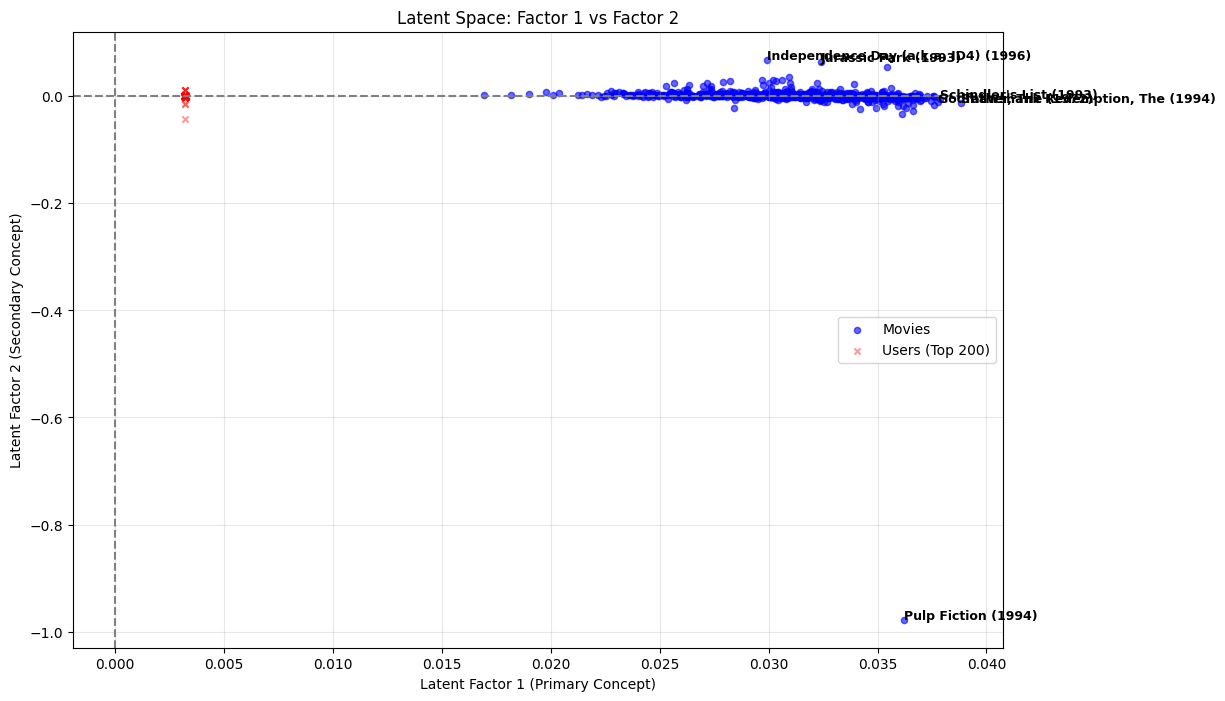

    Saved Plot: plots/latent_space.png


<Figure size 640x480 with 0 Axes>

In [21]:
# 6.3 Visualize Latent Space
plt.figure(figsize=(12, 8))

# Project using first 2 factors
item_x = V[:, 0]
item_y = V[:, 1]

# Plot all items (movies)
plt.scatter(item_x, item_y, alpha=0.6, s=20, label='Movies', c='blue', marker='o')

# Plot a sample of users (e.g., first 200 for clarity)
plt.scatter(U[:200, 0], U[:200, 1], alpha=0.4, s=20, label='Users (Top 200)', c='red', marker='x')

# Annotate top extremes for Factor 1
ext_1 = np.argsort(np.abs(item_x))[::-1][:3]
for idx in ext_1:
    m_id = R_df.columns[idx]
    title_rows = movies[movies['movieId'] == m_id]
    if len(title_rows) > 0:
        title = title_rows['title'].values[0]
        plt.text(item_x[idx], item_y[idx], title, fontsize=9, color='black', weight='bold')

# Annotate top extremes for Factor 2
ext_2 = np.argsort(np.abs(item_y))[::-1][:3]
for idx in ext_2:
    m_id = R_df.columns[idx]
    title_rows = movies[movies['movieId'] == m_id]
    if len(title_rows) > 0:
        title = title_rows['title'].values[0]
        plt.text(item_x[idx], item_y[idx], title, fontsize=9, color='black', weight='bold')

plt.title('Latent Space: Factor 1 vs Factor 2')
plt.xlabel('Latent Factor 1 (Primary Concept)')
plt.ylabel('Latent Factor 2 (Secondary Concept)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.axhline(0, color='grey', linestyle='--')
plt.axvline(0, color='grey', linestyle='--')
plt.show()
save_plot(plt, 'latent_space.png')

## Task 7: Sensitivity Analysis
1. **Robustness to Missing Data**: Test how SVD performance degrades as we remove more known ratings (e.g., 10%, 30%, 50%, 70% missing).
2. **Initialization Impact**: Compare filling missing values with Item Mean (Baseline) vs User Mean.


--- 7.1 Sensitivity Analysis: Robustness (Memory Optimized) --- 
Total Known Ratings: 1000000

Testing with 10.0% Masked...
  RMSE: 0.9175

Testing with 30.0% Masked...
  RMSE: 0.9198

Testing with 50.0% Masked...
  RMSE: 0.9205

Testing with 70.0% Masked...
  RMSE: 0.9222


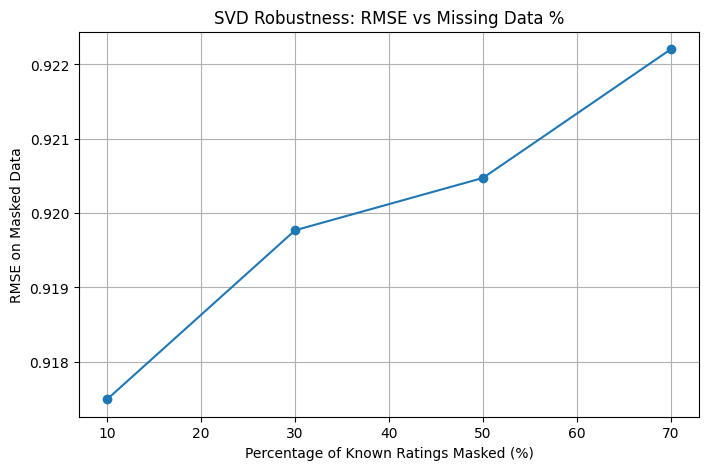

    Saved Plot: plots/svd_robustness.png


<Figure size 640x480 with 0 Axes>

In [22]:
import numpy as np
import matplotlib.pyplot as plt

print("\n--- 7.1 Sensitivity Analysis: Robustness (Memory Optimized) --- ")

# 1. Setup Data
R_sparse = R_df.values
known_u, known_i = np.where(~np.isnan(R_sparse))
num_known = len(known_u)
print(f"Total Known Ratings: {num_known}")

missing_pcts = [0.1, 0.3, 0.5, 0.7]
rmse_results = []

for pct in missing_pcts:
    print(f"\nTesting with {pct*100}% Masked...")
    num_mask = int(num_known * pct)
    
    # Mask indices
    np.random.seed(42)
    perm = np.random.permutation(num_known)
    mask_indices = perm[:num_mask]
    
    test_u = known_u[mask_indices]
    test_i = known_i[mask_indices]
    
    # Create Train Matrix (Allocates ~735MB)
    R_train = R_sparse.copy()
    R_train[test_u, test_i] = np.nan
    
    # --- MEMORY OPTIMIZED FILLING START ---
    
    # 1. Calculate Global Mean (Iteratively to avoid copy)
    # We compute sum and count without making a copy of the full matrix
    total_sum = 0.0
    total_count = 0
    
    # We will also cache column means to avoid re-computing
    col_means = np.zeros(R_train.shape[1])
    
    for col_idx in range(R_train.shape[1]):
        col_data = R_train[:, col_idx]
        valid_mask = ~np.isnan(col_data)
        
        if np.any(valid_mask):
            col_valid = col_data[valid_mask]
            c_sum = np.sum(col_valid)
            c_count = len(col_valid)
            
            col_means[col_idx] = c_sum / c_count
            total_sum += c_sum
            total_count += c_count
        else:
            col_means[col_idx] = np.nan # Mark empty column
            
    global_mean = total_sum / total_count if total_count > 0 else 0
    
    # 2. Fill In-Place (Column by Column)
    # This modifies R_train directly, avoiding a second 735MB allocation
    for col_idx in range(R_train.shape[1]):
        col_data = R_train[:, col_idx]
        nan_mask = np.isnan(col_data)
        
        if np.any(nan_mask):
            # Determine fill value (Col Mean or Global Mean)
            fill_val = col_means[col_idx]
            if np.isnan(fill_val):
                fill_val = global_mean
            
            # Assign in-place
            R_train[nan_mask, col_idx] = fill_val

    # R_train is now fully filled
    R_filled_train = R_train 
    
    # --- MEMORY OPTIMIZED FILLING END ---
    
    # SVD Implementation
    # RtR is small (1000x1000), so this is safe
    RtR = np.dot(R_filled_train.T, R_filled_train)
    evals, evecs = np.linalg.eigh(RtR)
    
    idx = evals.argsort()[::-1]
    evals = evals[idx]
    evecs = evecs[:, idx]
    
    k = 50
    s_k = np.sqrt(np.maximum(evals[:k], 0))
    V_k = evecs[:, :k]
    
    # U = R V S^-1
    # Note: R_filled_train (96k x 1k) * V_k (1k x 50) -> (96k x 50) result.
    # This allocation is small (~38MB). Safe.
    with np.errstate(divide='ignore', invalid='ignore'):
        S_inv = np.diag(1/s_k)
        S_inv[np.isinf(S_inv)] = 0
        
    U_k = np.dot(np.dot(R_filled_train, V_k), S_inv)
    
    # Predict
    # Only compute predictions for the test indices to save memory
    # Instead of full matrix R_hat = U_k . S . Vt (which creates another 735MB matrix),
    # we compute dot product row-by-row just for test items.
    
    # Optimize Prediction: R_hat_uv = U[u] . S . V[v].T
    # We can pre-compute U_dot_S = U_k * S
    U_S = np.dot(U_k, np.diag(s_k)) # (96345, 50)
    
    # Vectorized prediction for specific indices
    # pred[k] = U_S[test_u[k]] dot V_k[test_i[k]]
    # This is much faster and lighter than full matrix multiplication
    
    rows = U_S[test_u] # Shape (N_test, 50)
    cols = V_k[test_i] # Shape (N_test, 50)
    
    # Row-wise dot product
    pred_vals = np.sum(rows * cols, axis=1)
    true_vals = R_sparse[test_u, test_i]
    
    rmse = np.sqrt(np.mean((true_vals - pred_vals)**2))
    rmse_results.append(rmse)
    print(f"  RMSE: {rmse:.4f}")

# Plot
plt.figure(figsize=(8, 5))
plt.plot([p*100 for p in missing_pcts], rmse_results, marker='o', linestyle='-')
plt.title('SVD Robustness: RMSE vs Missing Data %')
plt.xlabel('Percentage of Known Ratings Masked (%)')
plt.ylabel('RMSE on Masked Data')
plt.grid(True)
plt.show()
save_plot(plt, 'svd_robustness.png')

In [23]:
import numpy as np
import pandas as pd

print("\n--- 7.2 Initialization Impact (User vs Item Mean) --- ")

# 1. Setup Data & Masking
R_sparse = R_df.values
known_u, known_i = np.where(~np.isnan(R_sparse))
num_known = len(known_u)

# Fixed 30% mask
pct = 0.3
num_mask = int(num_known * pct)
np.random.seed(99) 
mask_indices = np.random.permutation(num_known)[:num_mask]

test_u = known_u[mask_indices]
test_i = known_i[mask_indices]

# Create Train Matrix (with NaNs)
R_train = R_sparse.copy()
R_train[test_u, test_i] = np.nan

# Calculate Global Mean (Fallback)
global_mean = np.nanmean(R_train)

strategies = ['Item Mean', 'User Mean']
k = 50

for strategy in strategies:
    print(f"\nTesting {strategy}...")
    
    # Create a copy to fill (Allocates ~735MB, necessary)
    R_filled_train = R_train.copy()
    
    # --- MEMORY SAFE FILLING (Column-wise Loop) ---
    # We iterate 1000 columns (instant) instead of processing 100M entries at once.
    
    if strategy == 'Item Mean':
        # Pre-compute column means
        col_means = np.nanmean(R_train, axis=0)
        col_means[np.isnan(col_means)] = global_mean
        
        for j in range(R_filled_train.shape[1]):
            # 1. Identify missing rows in this column (Boolean mask, very small)
            nan_mask = np.isnan(R_filled_train[:, j])
            
            # 2. Fill in-place if there are any NaNs
            if np.any(nan_mask):
                R_filled_train[nan_mask, j] = col_means[j]
                
    else: # User Mean
        # Pre-compute row means
        row_means = np.nanmean(R_train, axis=1)
        row_means[np.isnan(row_means)] = global_mean
        
        for j in range(R_filled_train.shape[1]):
            # 1. Identify missing rows in this column
            nan_mask = np.isnan(R_filled_train[:, j])
            
            # 2. Fill in-place using the corresponding user's mean
            # We select the row_means for the users who are missing a rating in col j
            if np.any(nan_mask):
                R_filled_train[nan_mask, j] = row_means[nan_mask]

    # --- SVD CALCULATION ---
    RtR = np.dot(R_filled_train.T, R_filled_train)
    evals, evecs = np.linalg.eigh(RtR)
    
    idx = evals.argsort()[::-1]
    evals = evals[idx]
    evecs = evecs[:, idx]
    
    s_k = np.sqrt(np.maximum(evals[:k], 0))
    V_k = evecs[:, :k]
    
    # U = R V S^-1
    with np.errstate(divide='ignore', invalid='ignore'):
        S_inv = np.diag(1/s_k)
        S_inv[np.isinf(S_inv)] = 0
        
    U_k = np.dot(np.dot(R_filled_train, V_k), S_inv)
    
    # --- MEMORY OPTIMIZED PREDICTION ---
    # Calculate RMSE only on test indices
    U_S = np.dot(U_k, np.diag(s_k)) # (Users, k)
    
    user_vecs = U_S[test_u]    # (N_test, k)
    item_vecs = V_k[test_i]    # (N_test, k)
    
    pred_vals = np.sum(user_vecs * item_vecs, axis=1)
    
    true_vals = R_sparse[test_u, test_i]
    rmse = np.sqrt(np.mean((true_vals - pred_vals)**2))
    
    print(f"  {strategy} RMSE: {rmse:.4f}")


--- 7.2 Initialization Impact (User vs Item Mean) --- 

Testing Item Mean...
  Item Mean RMSE: 0.9198

Testing User Mean...


C:\Users\hadye\AppData\Local\Temp\ipykernel_22388\4242581712.py:54: RuntimeWarning: Mean of empty slice
  row_means = np.nanmean(R_train, axis=1)


  User Mean RMSE: 0.9944


## Task 8: Cold-Start Analysis & Mitigation
1. **Simulate Cold-Start**: Hide 80% of ratings for a subset of active users to mimic new users.
2. **Estimate Factors**: Use "Folding-In" (projection) to estimate latent factors for these users based on limited visible ratings.
3. **Evaluate**: Compare SVD prediction accuracy for Cold-Start vs Warm-Start users.
4. **Mitigation**: Test a Hybrid Strategy (SVD + Item Popularity) to improve Cold-Start performance.

In [24]:
# 8.1 & 8.2 Cold-Start Simulation & Estimation
print("\n--- 8.1 & 8.2 Cold-Start Analysis --- ")

# Select 50 active users (> 20 ratings)
user_counts = pd.Series(R_df.count(axis=1))
active_users = user_counts[user_counts > 20].index
np.random.seed(42)
target_users = np.random.choice(active_users, size=50, replace=False)

cold_rmses = []
warm_rmses = []

# We use the SVD model trained on the FULL dataset (V, s_k, S_inv from k=50)
# Ideally we would retrain SVD without these users, but folding-in is a valid estimation technique even if they were in training (just pretending we don't know their full history)

# V_k (1000, 50), s_k (50,), S_inv (50, 50) are available from Task 7 or 3 loop
# Let's re-extract k=50 components to be sure
k=50
# NOTE: we need R_filled_train from the full dataset (Task 2/3), let's re-run SVD quickly on full filled matrix if needed
# But variables U, singular_values, V from Task 2 are full rank. Let's slice them.
Vk_50 = V[:, :k]
sk_50 = singular_values[:k]
S_inv_50 = np.diag(1/sk_50)

print(f"Simulating Cold-Start for {len(target_users)} users...")

for u_id in target_users:
    # Get user's true ratings vector (sparse)
    u_idx = R_df.index.get_loc(u_id)
    true_vector = R_sparse[u_idx, :]
    known_indices = np.where(~np.isnan(true_vector))[0]
    
    # Hide 80%
    if len(known_indices) < 5: continue # Skip if too few
    num_hide = int(len(known_indices) * 0.8)
    hidden_indices = np.random.choice(known_indices, size=num_hide, replace=False)
    visible_indices = [x for x in known_indices if x not in hidden_indices]
    
    # Construct "Walking-In" Vector (Limited History)
    # Fill unrated/hidden with Item Means (Global Baseline)
    # Note: item_means is a Series from Task 1
    r_new = true_vector.copy()
    r_new[hidden_indices] = np.nan # Hide truth
    
    # Fill NaNs
    # We must start from a vector of NaNs, put explicit ratings, then fill rest
    r_filled = np.copy(r_new)
    # For indices that are NaN, fill with item_means
    for i in range(len(r_filled)):
        if np.isnan(r_filled[i]):
            r_filled[i] = (item_means.values if hasattr(item_means, 'values') else item_means)[i] if hasattr(item_means, 'values') else item_means[i]
            
    # Estimate Latent Factor (Folding-In)
    # u_est = r_filled . V_k . S_k^-1
    u_est = np.dot(np.dot(r_filled, Vk_50), S_inv_50)
    
    # Predict All
    # r_pred = u_est . S_k . V_k^T
    r_pred = np.dot(np.dot(u_est, np.diag(sk_50)), Vk_50.T)
    
    # Calc Error on HIDDEN (Cold Start Simulation)
    err_cold = true_vector[hidden_indices] - r_pred[hidden_indices]
    cold_rmses.append(np.sqrt(np.mean(err_cold**2)))
    
    # Calc Error on VISIBLE (Warm Fit - just for comparison)
    # Though technically 'visible' is what we fit on, so it's training error
    err_warm = true_vector[visible_indices] - r_pred[visible_indices]
    warm_rmses.append(np.sqrt(np.mean(err_warm**2)))

avg_cold_rmse = np.mean(cold_rmses)
avg_warm_rmse = np.mean(warm_rmses)
print(f"Average RMSE (Cold-Start / Hidden): {avg_cold_rmse:.4f}")
print(f"Average RMSE (Training Fit): {avg_warm_rmse:.4f}")


--- 8.1 & 8.2 Cold-Start Analysis --- 
Simulating Cold-Start for 50 users...
Average RMSE (Cold-Start / Hidden): 0.8995
Average RMSE (Training Fit): 0.8694



--- 8.4 Mitigation: Hybrid Strategy --- 
Alpha 0.0 : RMSE 0.9202
Alpha 0.2 : RMSE 0.9188
Alpha 0.5 : RMSE 0.9167
Alpha 0.8 : RMSE 0.9165
Alpha 1.0 : RMSE 0.9281


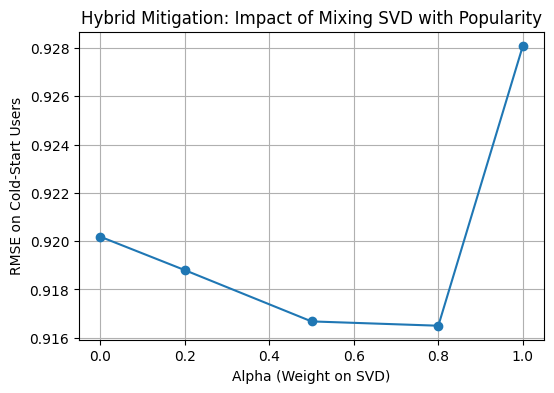

    Saved Plot: plots/hybrid_mitigation.png


<Figure size 640x480 with 0 Axes>

In [25]:
# 8.4 Mitigation: Hybrid Strategy (SVD + Popularity)
print("\n--- 8.4 Mitigation: Hybrid Strategy --- ")

# Strategy: Weighted Average
# Prediction = alpha * SVD_Pred + (1-alpha) * Item_Mean_Rating
# We reuse the predictions from loop above to test alpha impact globally

alphas = [0.0, 0.2, 0.5, 0.8, 1.0]
results = []

# Re-run loop briefly or efficiently using stored data? 
# Let's re-run loop for clarity in notebook structure

for alpha in alphas:
    curr_rmses = []
    for u_id in target_users:
        # ... same setup ...
        u_idx = R_df.index.get_loc(u_id)
        true_vector = R_sparse[u_idx, :]
        known_indices = np.where(~np.isnan(true_vector))[0]
        if len(known_indices) < 5: continue
        num_hide = int(len(known_indices) * 0.8)
        # For consistent comparison, set seed per user or use same indices
        # For demo, random again is okay as we average over 50 users
        hidden_indices = np.random.choice(known_indices, size=num_hide, replace=False)
        visible_indices = [x for x in known_indices if x not in hidden_indices]
        
        r_new = true_vector.copy()
        r_new[hidden_indices] = np.nan
        r_filled = np.copy(r_new)
        for i in range(len(r_filled)):
            if np.isnan(r_filled[i]): r_filled[i] = (item_means.values if hasattr(item_means, 'values') else item_means)[i] if hasattr(item_means, 'values') else item_means[i]
            
        # SVD Pred
        u_est = np.dot(np.dot(r_filled, Vk_50), S_inv_50)
        svd_pred = np.dot(np.dot(u_est, np.diag(sk_50)), Vk_50.T)
        
        # Hybrid Pred
        # Item Popularity is just item_means (broadcasted)
        pop_pred = item_means.values if hasattr(item_means, 'values') else item_means
        
        hybrid_pred = alpha * svd_pred + (1 - alpha) * pop_pred
        
        err = true_vector[hidden_indices] - hybrid_pred[hidden_indices]
        curr_rmses.append(np.sqrt(np.mean(err**2)))
        
    avg_rmse = np.mean(curr_rmses)
    results.append(avg_rmse)
    print(f"Alpha {alpha:.1f} : RMSE {avg_rmse:.4f}")

plt.figure(figsize=(6, 4))
plt.plot(alphas, results, marker='o')
plt.title('Hybrid Mitigation: Impact of Mixing SVD with Popularity')
plt.xlabel('Alpha (Weight on SVD)')
plt.ylabel('RMSE on Cold-Start Users')
plt.grid(True)
plt.show()
save_plot(plt, 'hybrid_mitigation')